## Data Loading and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
# Load the dataset
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

## Exploratory Data Analysis (EDA)

In [9]:
print(f"Shape of the Training Dataset: {train_data.shape}")
print(f"Shape of the Testing Dataset: {test_data.shape}")

Shape of the Training Dataset: (89392, 12)
Shape of the Testing Dataset: (59595, 11)


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


In [13]:
train_data.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.000000,89392.000000,89392.000000,89392.000000,89392.000000
mean,44696.500000,0.575488,4.595669,4351.502416,97952.828978
std,25805.391969,0.494272,2.290446,3262.359775,90613.814793
min,1.000000,0.000000,0.000000,0.000000,24828.000000
25%,22348.750000,0.000000,3.000000,2406.000000,52836.000000
50%,44696.500000,1.000000,5.000000,4089.000000,66396.000000
75%,67044.250000,1.000000,6.000000,6094.000000,103440.000000
max,89392.000000,1.000000,8.000000,31894.000000,724068.000000


In [15]:
# Checking for missing values in both datasets
print(f"Training Data Missing Values: {train_data.isnull().sum()}")
print("\n")
print(f"Test Data Missing Values: {test_data.isnull().sum()}")

Training Data Missing Values: id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64


Test Data Missing Values: id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
dtype: int64


In [17]:
from ydata_profiling import ProfileReport
train_report = ProfileReport(train_data, title = "Train Data Analysis")
train_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.67it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Target Variable Analysis

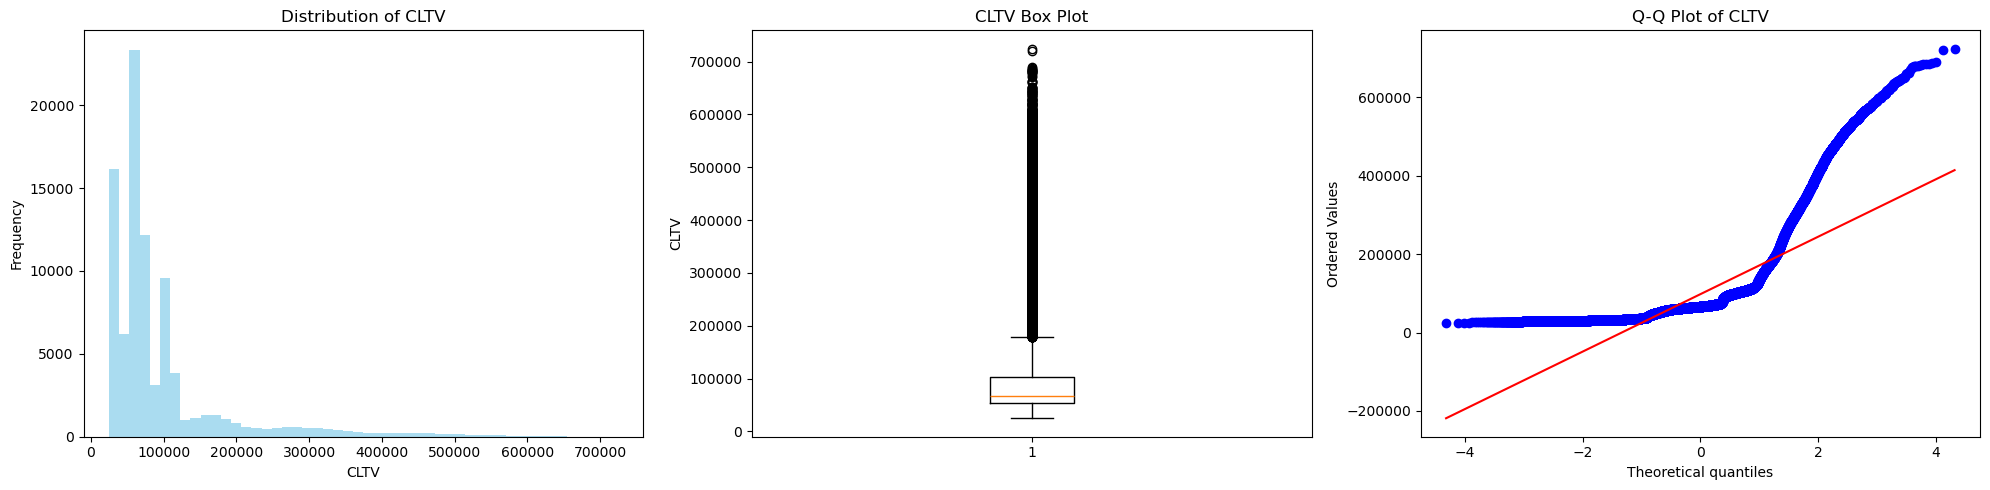

In [20]:
# Analysing the target variable (CLTV)
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(train_data["cltv"], bins=50, alpha=0.7, color="skyblue")
plt.title("Distribution of CLTV")
plt.xlabel("CLTV")
plt.ylabel("Frequency")

plt.subplot(1,3,2)
plt.boxplot(train_data["cltv"])
plt.title("CLTV Box Plot")
plt.ylabel("CLTV")

plt.subplot(1,3,3)
from scipy import stats
stats.probplot(train_data["cltv"], dist="norm", plot=plt)
plt.title("Q-Q Plot of CLTV")

plt.tight_layout()
plt.show()

In [22]:
# Check skewness and kurtosis
print(f"CLTV Skewness: {train_data['cltv'].skew():.3f}")
print(f"CLTV Kurtosis: {train_data['cltv'].kurtosis():.3f}")

CLTV Skewness: 2.753
CLTV Kurtosis: 8.334


## Categorical Variable Analysis

In [25]:
# Categorical Feature analysis
categorical_features = ["gender", "area", "qualification", "income", "marital_status", "num_policies", "policy", "type_of_policy"]
# numerical_features = ["vintage", "claim_amount"]

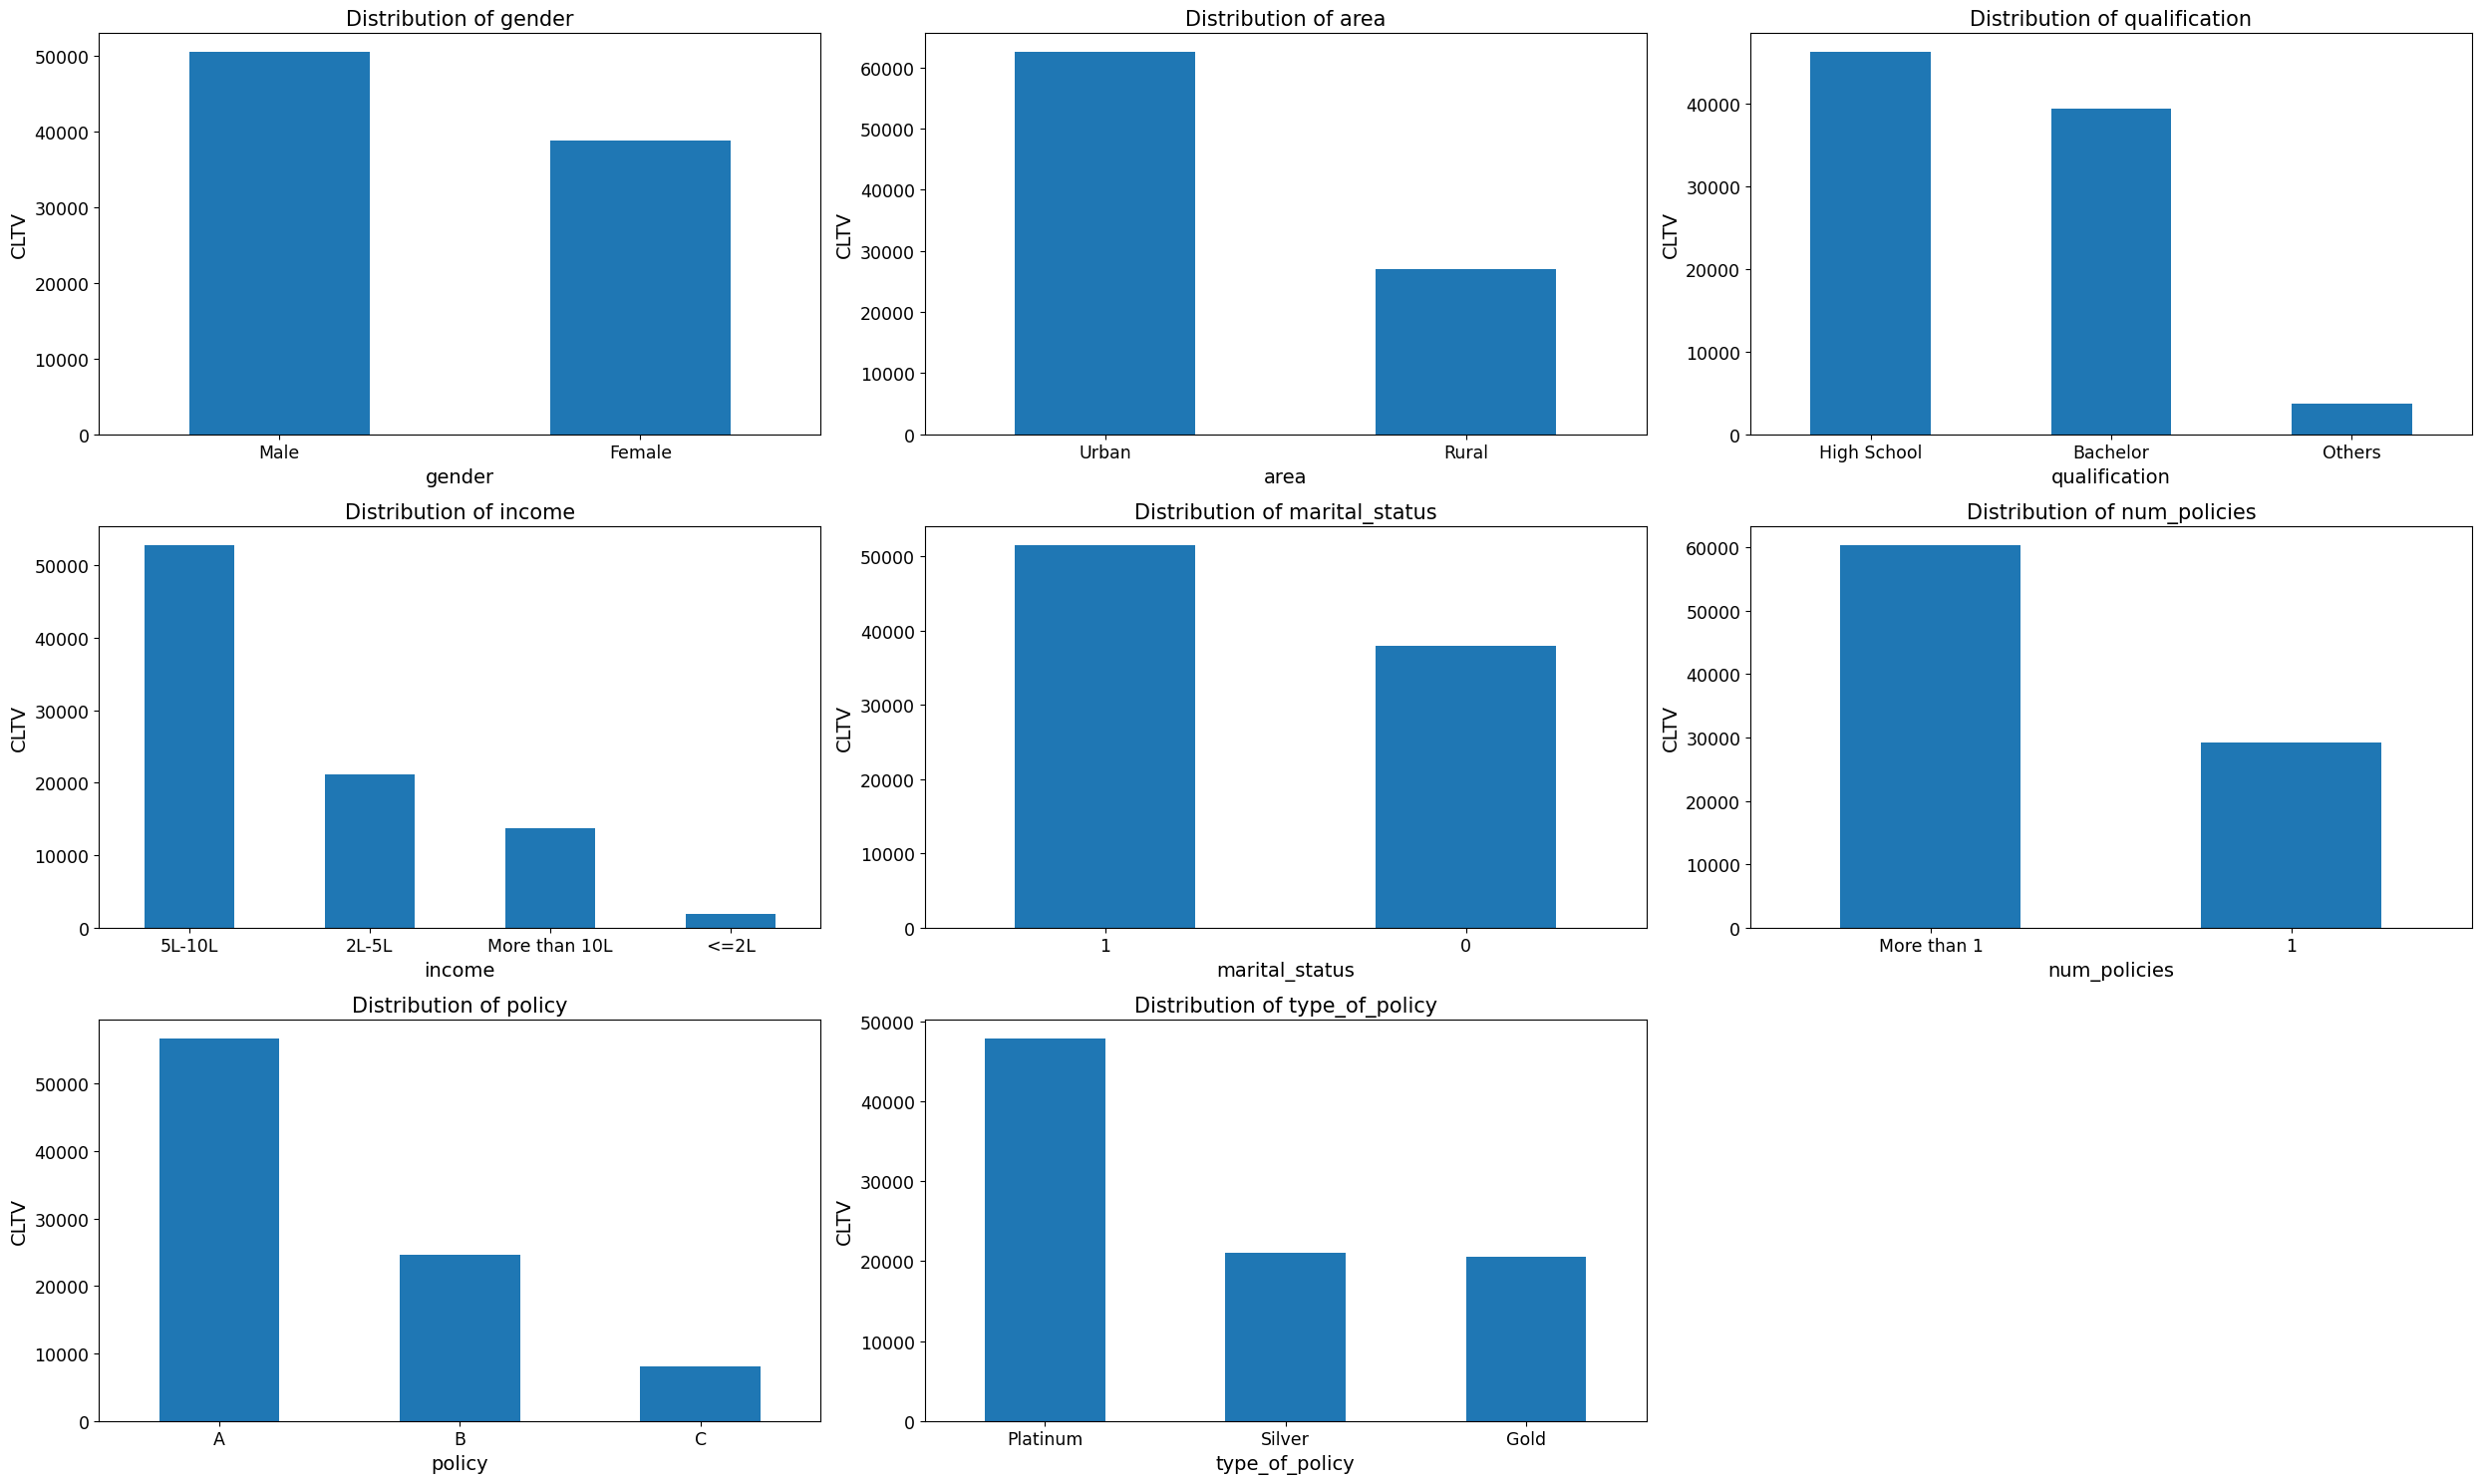

In [27]:
# Plotting categorical features
fig, axes = plt.subplots(3,3, figsize=(25, 15))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    train_data[feature].value_counts().plot(kind="bar",ax=axes[i]) 
    axes[i].set_title(f"Distribution of {feature}", fontsize=15)
    axes[i].tick_params(axis="x", rotation=360)
    
    axes[i].set_xlabel(feature, fontsize=14)
    axes[i].set_ylabel("CLTV", fontsize=14)

    for tick in axes[i].get_xticklabels():
        tick.set_fontsize(12.5)
    for tick in axes[i].get_yticklabels():
        tick.set_fontsize(12.5)

fig.delaxes(axes[8])
plt.tight_layout()
plt.show()

## Correlation Analysis

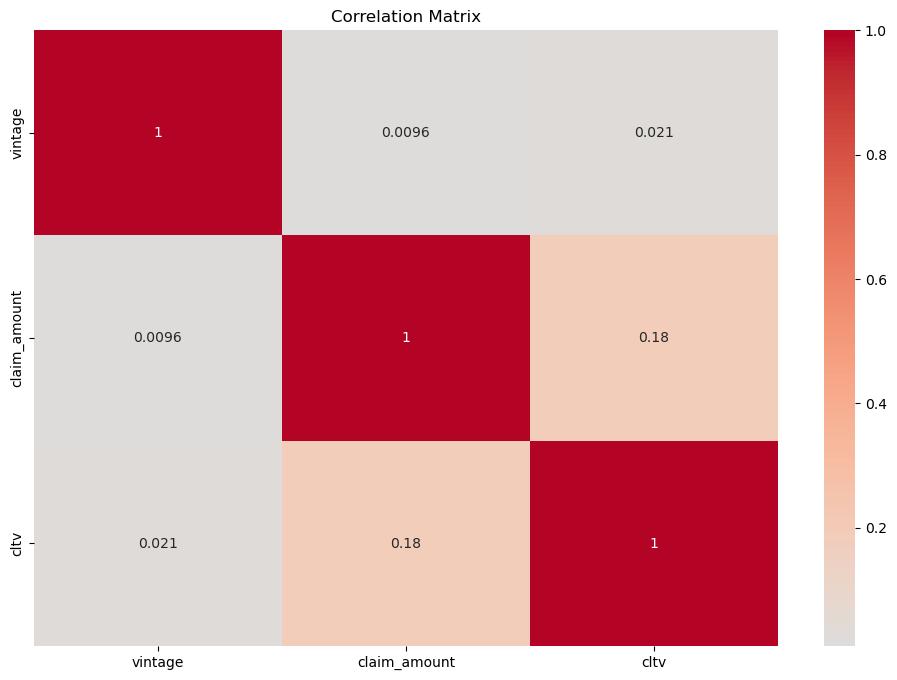

In [30]:
# Creating a correlation heatmap for the numerical variables
numerical_features = ["vintage", "claim_amount", "cltv"]

plt.figure(figsize=(12, 8))

correlation_matrix = train_data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

## CLTV vs Categorical Variables

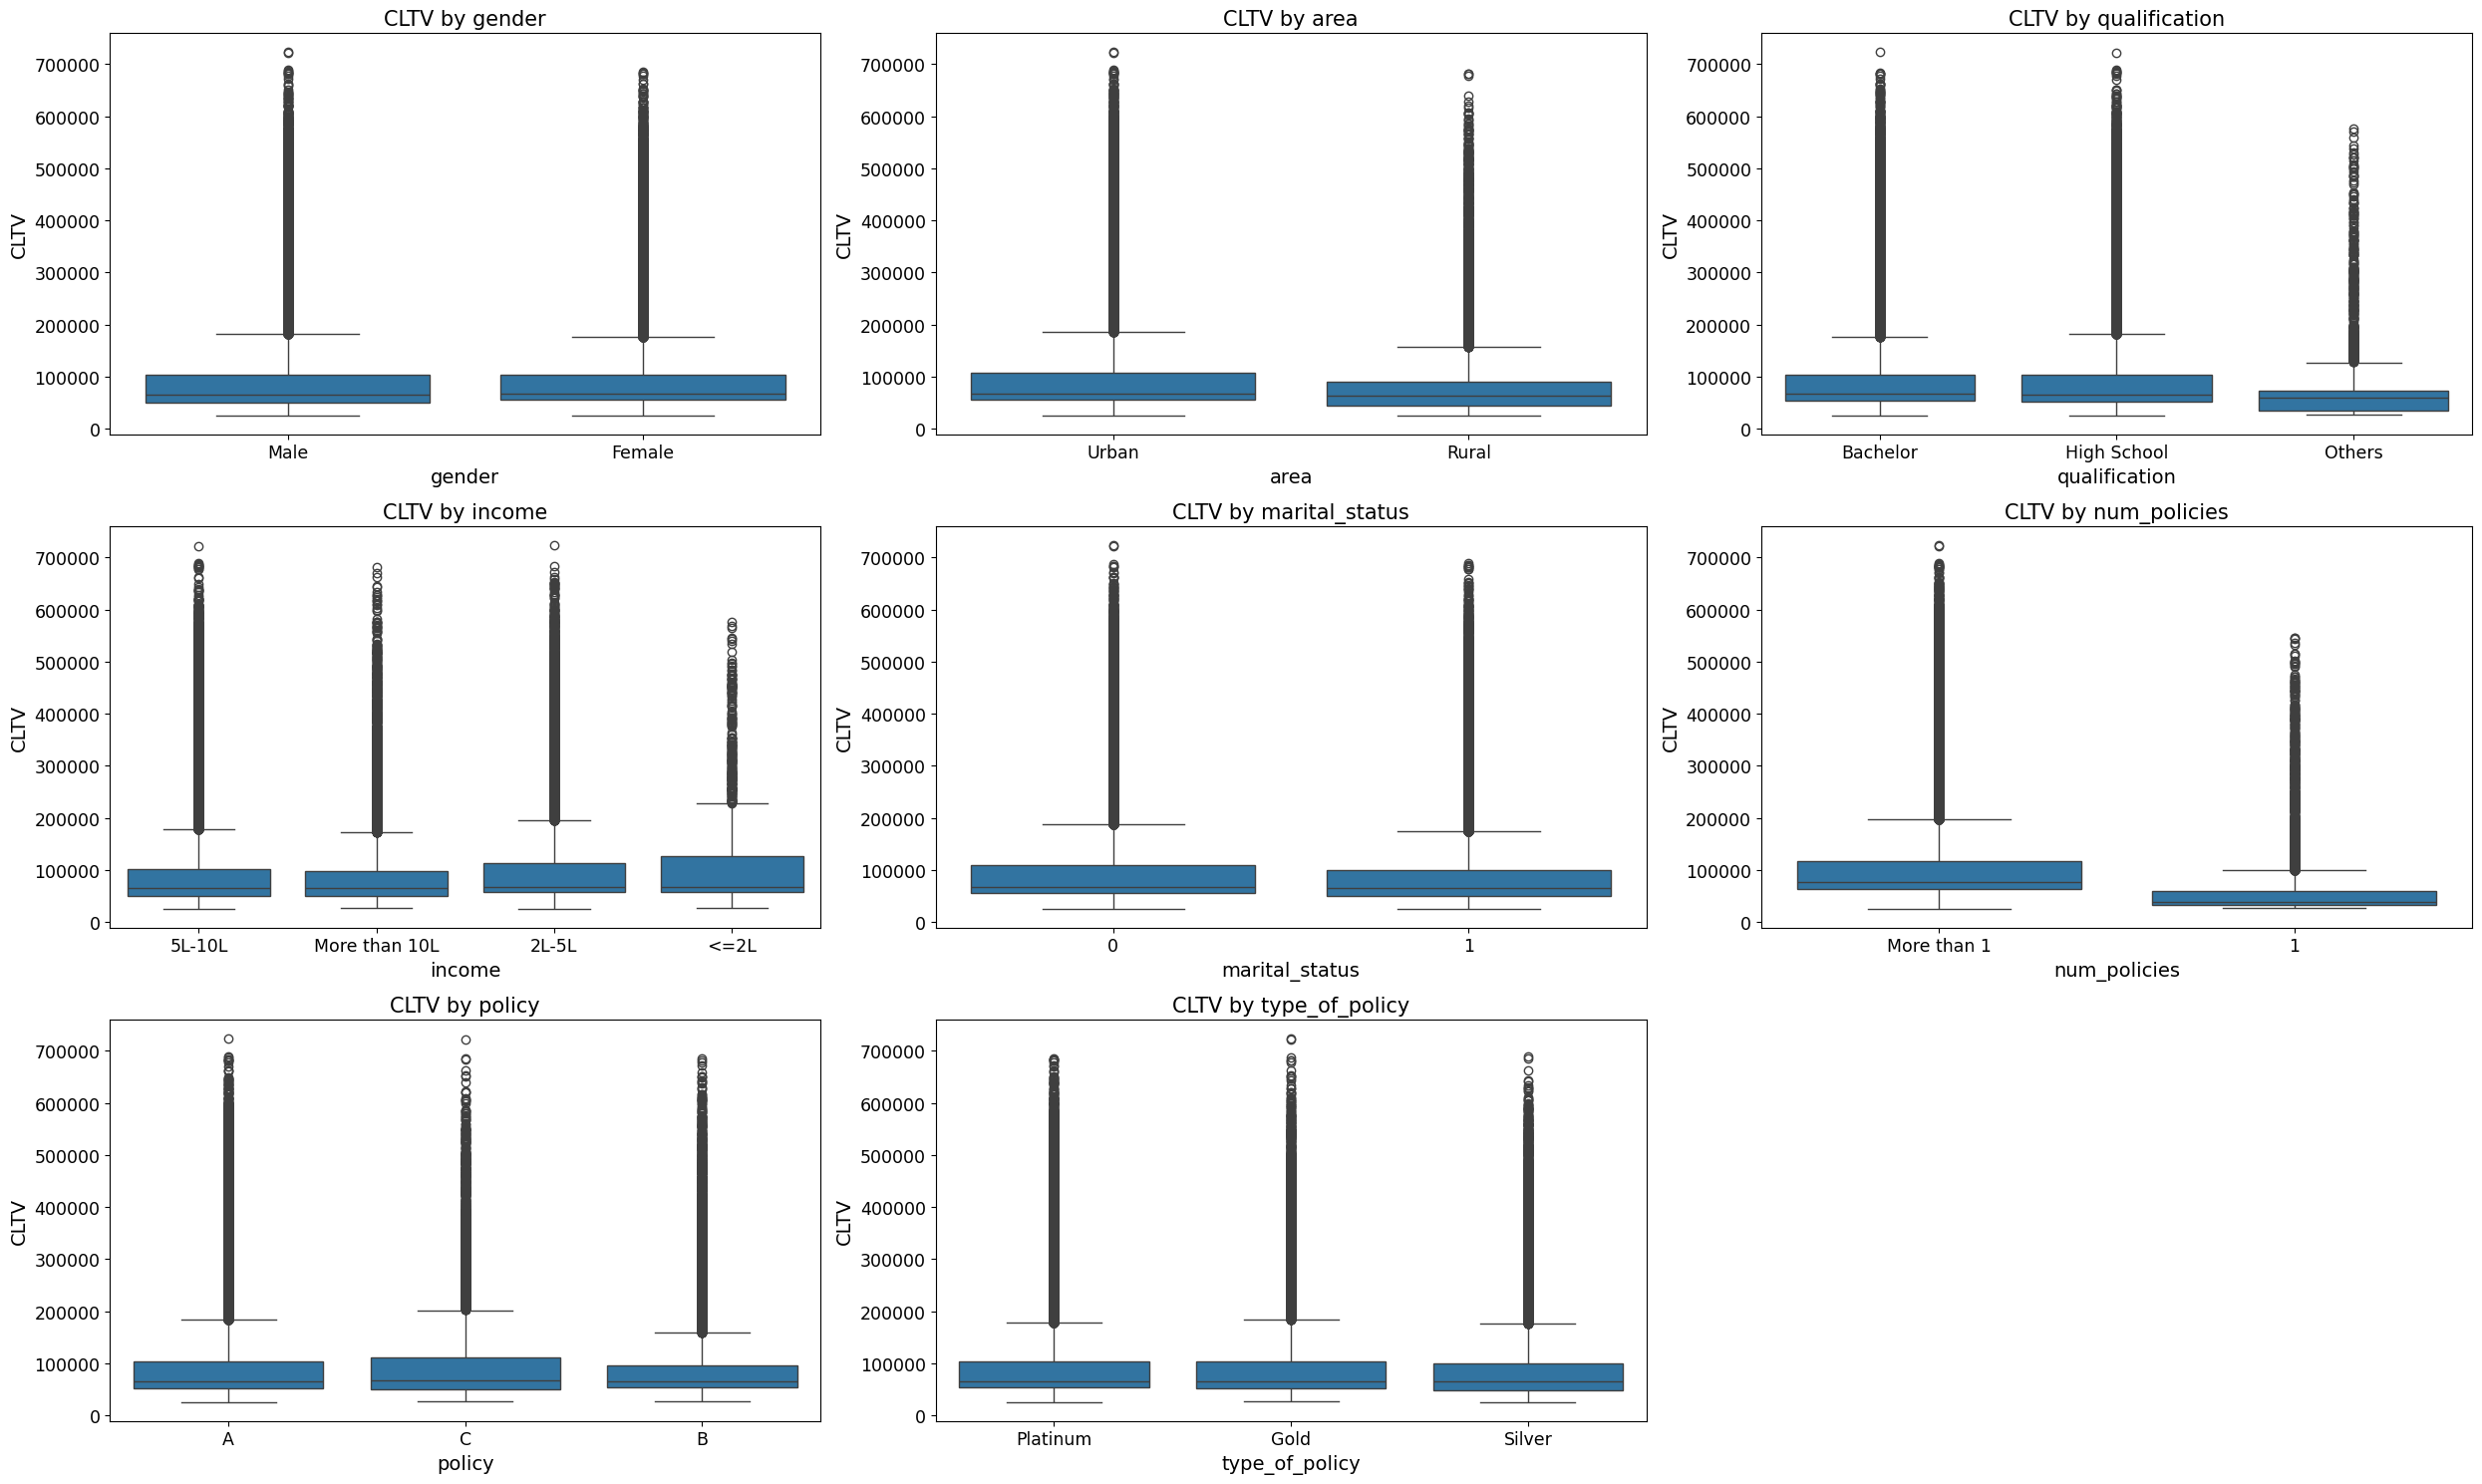

In [33]:
# Plotting categorical features vs CLTV
fig, axes = plt.subplots(3,3, figsize=(25, 15))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    sns.boxplot(data=train_data, x=feature, y="cltv", ax=axes[i])
    axes[i].set_title(f"CLTV by {feature}", fontsize=15)
    # axes[i].tick_params(axis="x", rotation=45)
    
    axes[i].set_xlabel(feature, fontsize=14)
    axes[i].set_ylabel("CLTV", fontsize=14)

    for tick in axes[i].get_xticklabels():
        tick.set_fontsize(12.5)
    for tick in axes[i].get_yticklabels():
        tick.set_fontsize(12.5)

fig.delaxes(axes[8])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [36]:
# Create a copy of the dataset for preprocessing
train_data_processed = train_data.copy()

In [38]:
# Convering the income column to numericql
def process_income(income_str):
    if income_str == '<=2L':
        return 1  # Midpoint of 0–2L
    elif income_str == '2L-5L':
        return 3.5  # Midpoint of 2–5L
    elif income_str == '5L-10L':
        return 7.5  # Midpoint of 5–10L
    elif income_str == 'More than 10L':
        return 15  # Assumed value for >10L
    else:
        return None  # Handle unexpected values

train_data_processed["income_numeric"] = train_data_processed["income"].apply(process_income)

In [40]:
# Handling the num_policies column
def process_num_policies(policy_str):
    if policy_str == "1":
        return 1
    elif policy_str == "More than 1":
        return 3
    else:
        return 1 # Default feedback

train_data_processed["num_policies_numeric"] = train_data_processed["num_policies"].apply(process_num_policies)

In [42]:
# Label encode other categorical variables
label_encoders = {}
categorical_to_encode = ["gender", "area", "qualification", "policy", "type_of_policy"]

for feature in categorical_to_encode:
    le = LabelEncoder()
    train_data_processed[f"{feature}_encoded"] = le.fit_transform(train_data_processed[feature])
    label_encoders[feature] = le

print(f"New Shape: {train_data_processed.shape}")

New Shape: (89392, 19)


In [44]:
train_data_processed.head(5)

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,income_numeric,num_policies_numeric,gender_encoded,area_encoded,qualification_encoded,policy_encoded,type_of_policy_encoded
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308,7.5,3,1,1,0,0,1
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400,7.5,3,1,0,1,0,1
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212,7.5,3,1,1,0,0,1
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920,7.5,3,0,0,1,0,1
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736,15.0,3,1,1,1,0,0


## Feature Selection

In [47]:
# Selecting features for the model
feature_columns = ['gender_encoded', 'area_encoded', 'qualification_encoded', 
                  'income_numeric', 'marital_status', 'vintage', 'claim_amount',
                  'num_policies_numeric', 'policy_encoded', 'type_of_policy_encoded']

x = train_data_processed[feature_columns]
y = train_data_processed["cltv"]

print("Selected Features:")
print(x.columns.tolist())
print(f"Feature matrix shape: {x.shape}")
print(f"Target vector shape: {y.shape}")

Selected Features:
['gender_encoded', 'area_encoded', 'qualification_encoded', 'income_numeric', 'marital_status', 'vintage', 'claim_amount', 'num_policies_numeric', 'policy_encoded', 'type_of_policy_encoded']
Feature matrix shape: (89392, 10)
Target vector shape: (89392,)


## Handling Skewness in the Target Variable

In [50]:
# Checking for skewness and handling it in the target variable
print(f"Original CLTV skewness: {y.skew():.3f}")

Original CLTV skewness: 2.753


Log-transformed CLTV skewness: 0.909


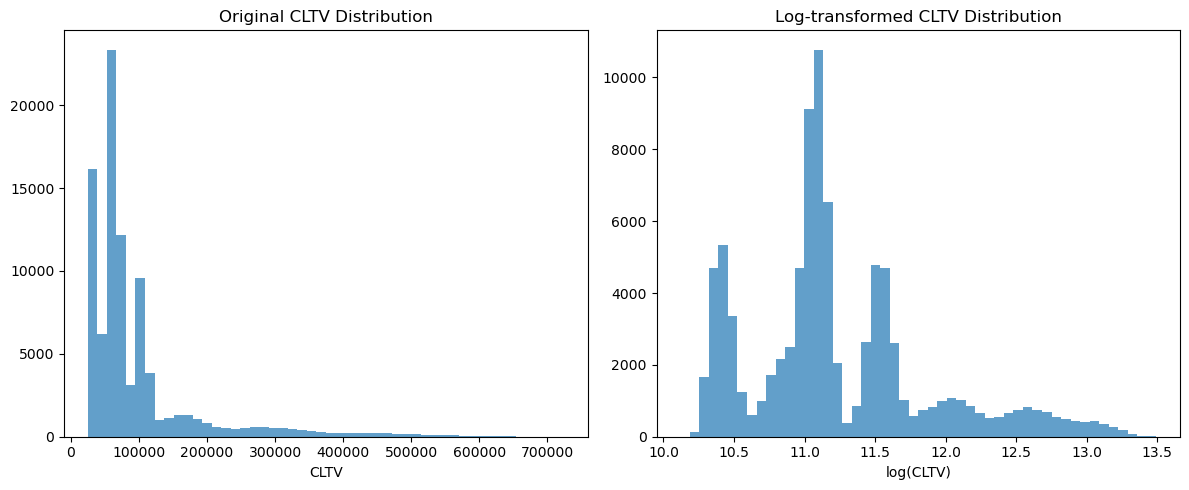

Using the log transformation: True


In [52]:
# Apply log transformation to fix high skewness
if abs(y.skew()) > 1:
    y_transformed = np.log1p(y)
    print(f"Log-transformed CLTV skewness: {y_transformed.skew():.3f}")
    
    # Visualize the transformation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(y, bins=50, alpha=0.7)
    ax1.set_title("Original CLTV Distribution")
    ax1.set_xlabel("CLTV")
    
    ax2.hist(y_transformed, bins=50, alpha=0.7)
    ax2.set_title("Log-transformed CLTV Distribution")
    ax2.set_xlabel("log(CLTV)")
    
    plt.tight_layout()
    plt.show()
    
    y = y_transformed
    use_log_transform = True
else:
    use_log_transform = False

print(f"Using the log transformation: {use_log_transform}")

## Feature Engineering

In [55]:
# Create additional features
x["claim_per_policy"] = x["claim_amount"]/(x["num_policies_numeric"] + 1)
x["claim_per_year"] = x["claim_amount"]/(x["vintage"] + 1)
x["policy_per_year"] = x["num_policies_numeric"]/(x["vintage"] + 1)

In [57]:
# Create interaction features
x["income_vintage_interaction"] = x["income_numeric"] * x["vintage"]
x["hgh_value_customer"] = ((x["income_numeric"]>10) & (x["num_policies_numeric"] > 1)).astype(int)

print("The new features created:")
print(x.columns.tolist())

The new features created:
['gender_encoded', 'area_encoded', 'qualification_encoded', 'income_numeric', 'marital_status', 'vintage', 'claim_amount', 'num_policies_numeric', 'policy_encoded', 'type_of_policy_encoded', 'claim_per_policy', 'claim_per_year', 'policy_per_year', 'income_vintage_interaction', 'hgh_value_customer']


## Handling the Outlier

In [60]:
# Identify the outliers and handling them using the IQR method
def handle_outliers(train_data, columns, method="iqr"):
    train_data_clean = train_data.copy()
    
    for feature in columns:
        if method == "iqr":
            Q1 = train_data[feature].quantile(0.25)
            Q3 = train_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap the outliers instead of removing them
            train_data_clean[feature] = train_data_clean[feature].clip(lower=lower_bound, upper=upper_bound)
    
    return train_data_clean

In [62]:
# Handle outliers in numerical columns
numerical_features = ['vintage', 'claim_amount', 'income_numeric', 'claim_per_policy', 
                     'claim_per_year', 'policy_per_year']
X_clean = handle_outliers(x, numerical_features)

## Model Building

In [65]:
# Split the data for a train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (71513, 15)
Test set shape: (17879, 15)


## Feature Scaling

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.fit_transform(x_test)

# Convert back to the dataframe to make it interpretable
X_train_scaled = pd.DataFrame(X_train_scaled, columns=x_train.columns, index=x_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)

## Model Training and Comparison

In [71]:
# Define the models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Rgression": Lasso(alpha=1.0),
    "Ramdom Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [73]:
# Train and evaluate the models
models_results = {}
trained_models = {}

for name, model in models.items():
    # Train the model
    if "Regression" in name and name != "Linear Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
    # Calculate the metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    models_results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }
    
    trained_models[name] = model
    print(f"{name}:")
    print(f" RMSE: {rmse:.4f}")
    print(f" R2: {r2:.4f}")
    print(f" MAE: {mae:.4f}")
    print()

results_df = pd.DataFrame(models_results).T
print("Model Comparison Results:")
print(results_df.round(4))

Linear Regression:
 RMSE: 0.5327
 R2: 0.3231
 MAE: 0.4117

Ridge Regression:
 RMSE: 0.5328
 R2: 0.3229
 MAE: 0.4121

Lasso Rgression:
 RMSE: 0.5610
 R2: 0.2494
 MAE: 0.4274

Ramdom Forest:
 RMSE: 0.5700
 R2: 0.2251
 MAE: 0.4368

Gradient Boosting:
 RMSE: 0.5311
 R2: 0.3273
 MAE: 0.4096

Model Comparison Results:
                      MSE    RMSE      R2     MAE
Linear Regression  0.2838  0.5327  0.3231  0.4117
Ridge Regression   0.2839  0.5328  0.3229  0.4121
Lasso Rgression    0.3147  0.5610  0.2494  0.4274
Ramdom Forest      0.3249  0.5700  0.2251  0.4368
Gradient Boosting  0.2821  0.5311  0.3273  0.4096


# Hyperparameter Tuning for the Best Model

In [76]:
# Select the best model based on the R2 score
best_model_name = results_df["R2"].idxmax()
print(f"Best Model: {best_model_name}")

Best Model: Gradient Boosting


In [78]:
# Hyperparameter tuning for the best model
if best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [100,200,300],
        "max_depth": [10,20,None],
        "min_samples_split": [2,5,10],
        "min_samples_leaf": [1,2,4]
    }
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        "n_estimators": [100,200,300],
        "learning_rate": [0.01,0.1,0.2],
        "max_depth": [3,5,7],
        "subsample": [0.8,0.9,1.0]
    }
    
    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_estimator_}")

Best Parameters: GradientBoostingRegressor(random_state=42, subsample=0.8)


## Model Evaluation and interpretation

In [80]:
# Getting the final prediction with tuned model
y_pred_final = best_model.predict(x_test)

In [82]:
# Calculate the final metrics
final_mse = mean_squared_error(y_test, y_pred_final)
final_rsme = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)

print("Final Model Performance:")
print(f"RMSE: {final_rsme:.4f}")
print(f"R2: {final_r2:.4f}")
print(f"MAE: {final_mae:.4f}")

Final Model Performance:
RMSE: 0.5309
R2: 0.3278
MAE: 0.4094


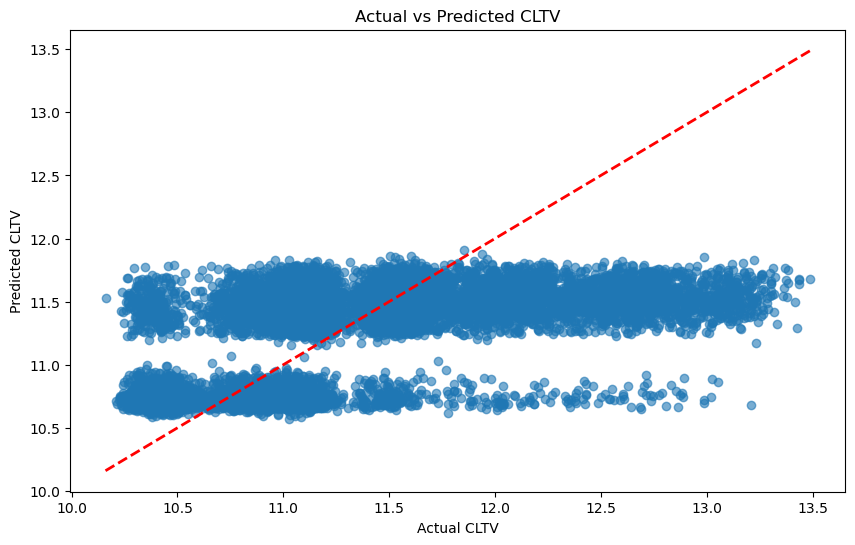

In [88]:
# Predictions vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Actual vs Predicted CLTV")
plt.show()

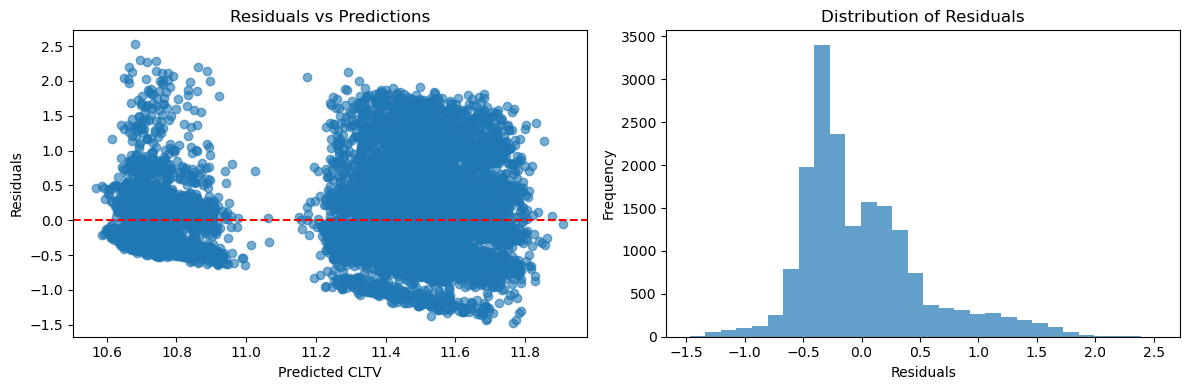

In [90]:
# Residual analysis
residuals = y_test - y_pred_final
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted CLTV')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

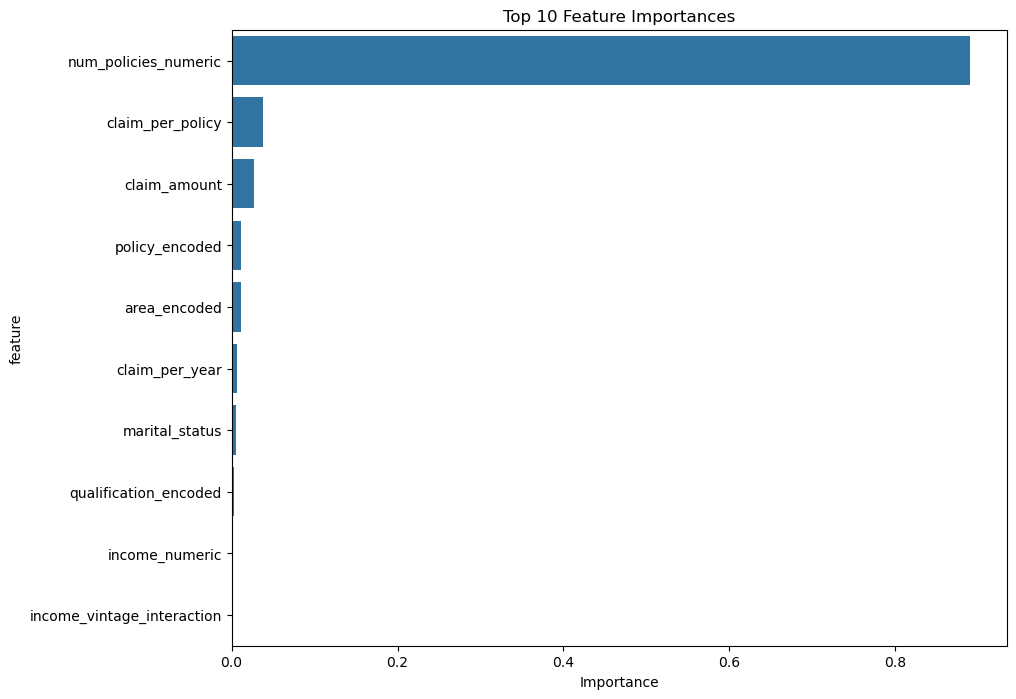

Top 10 Most Important Features:
                       feature  importance
7         num_policies_numeric    0.889896
10            claim_per_policy    0.037956
6                 claim_amount    0.027121
8               policy_encoded    0.011186
1                 area_encoded    0.011176
11              claim_per_year    0.006051
4               marital_status    0.005483
2        qualification_encoded    0.002699
3               income_numeric    0.002147
13  income_vintage_interaction    0.002086


In [92]:
# Feature importance analysis
if hasattr(best_model, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "feature": x_train.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    plt.figure(figsize=(10,8))
    sns.barplot(data=feature_importance.head(10), x="importance", y="feature")
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

## Customer Segmentation Based on the CLTV

In [95]:
# Convert predictions back to original scale
if use_log_transform:
    y_pred_original_scale = np.expm1(y_pred_final)
    y_test_original_scale = np.expm1(y_test)
else:
    y_pred_original_scale = y_pred_final
    y_test_original_scale = y_test

In [97]:
# Create customer segments based on predicted CLTV
def create_customer_tiers(cltv_values):
    tiers = pd.cut(cltv_values,
                   bins=3,
                   labels=["Bronze", "Silver", "Gold"],
                   include_lowest=True)
    return tiers

predicted_tiers = create_customer_tiers(y_pred_original_scale)
actual_tiers = create_customer_tiers(y_test_original_scale)

In [99]:
# Display the tier distribution
print("Predicted Customer Tier Distribution:")
print(predicted_tiers.value_counts())
print("\nActual Customer Tier Distribution:")
print(actual_tiers.value_counts())

Predicted Customer Tier Distribution:
Bronze     5919
Silver    10233
Gold       1727
Name: count, dtype: int64

Actual Customer Tier Distribution:
cltv
Bronze    16623
Silver     1089
Gold        167
Name: count, dtype: int64
